 Use two images namely defected and normal image(upload it in the files folder and then follow the further instructions to Create DIR

In [ ]:
import os 

os.mkdir("/content/train")

directory = "normal"

#Parent Dir
parent_dir = "/content/train"

#Path 
path = os.path.join(parent_dir, directory) 

os.mkdir(path) 
print("Directory '%s' created" %directory) 

directory = "defected" 
parent_dir = "/content/train"


#Path 
path = os.path.join(parent_dir, directory) 

os.mkdir(path) 
print("Directory '%s' created" %directory) 


Directory 'normal' created
Directory 'defected' created


# Get required Lib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/content/good_image.png') 
x = img_to_array(img)
x = x.reshape((1,) + x.shape) 

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/content/train/normal', save_prefix='goodi', save_format='jpeg'):
    i += 1
    if i > 1000:
        break  #otherwise the generator would loop indefinitely

In [ ]:
img = load_img('/content/bad_image.png')  
x = img_to_array(img)  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='train/defected', save_prefix='badi', save_format='jpeg'):
    i += 1
    if i > 1000:
        break  # otherwise the generator would loop indefinitely

In [ ]:
goodimg = os.listdir('/content/train/normal')
print("Number of normal Images: ", len(goodimg))

Number of normal Images:  952


In [ ]:
badimg = os.listdir('/content/train/defected/')
print("Number of defected Images: ", len(badimg))

Number of defected Images:  953


Visualize the Normal Images

*****************Random Images with Cracks**************************
goodi_0_6343.jpeg


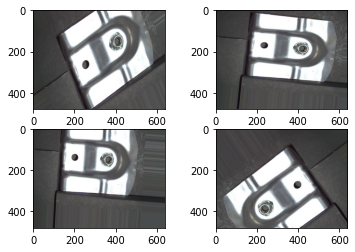

In [ ]:
random_indices = np.random.randint(0, len(goodimg), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(goodimg)[random_indices.astype(int)]
print(random_images[0])
path = '/content/train/normal/'
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(path, random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(path, random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(path, random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(path, random_images[3])))

Visualize the Normal Images

*****************Random Images with Cracks**************************
badi_0_279.jpeg


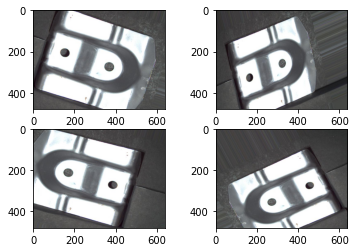

In [ ]:
random_indices = np.random.randint(0, len(badimg), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(badimg)[random_indices.astype(int)]
print(random_images[0])
path = '/content/train/defected/'
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(path, random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(path, random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(path, random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(path, random_images[3])))

In [ ]:
base_dir = cwd
files = os.listdir(base_dir)

In [ ]:
os.makedirs('val/normal')
os.makedirs('val/defected')

In [ ]:
positive_train = base_dir + "/train/normal/"
positive_val = base_dir + "/val/normal/"
negative_train = base_dir + "/train/defected/"
negative_val = base_dir + "/val/defected/"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

In [ ]:

print(len(positive_files), len(negative_files))

952 953


In [ ]:
for f in positive_files[:900]:
    if random.random() > 0.80:
        shutil.move(f'{positive_train}/{f}', positive_val)

In [ ]:
for f in negative_files[:900]:
    if random.random() > 0.80:
        shutil.move(f'{negative_train}/{f}', negative_val)

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

In [ ]:
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
#data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [ ]:
#run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  1560
Class Names are:  ['defected', 'normal']
torch.Size([8, 3, 227, 227]) torch.Size([8])


In [ ]:
#Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated


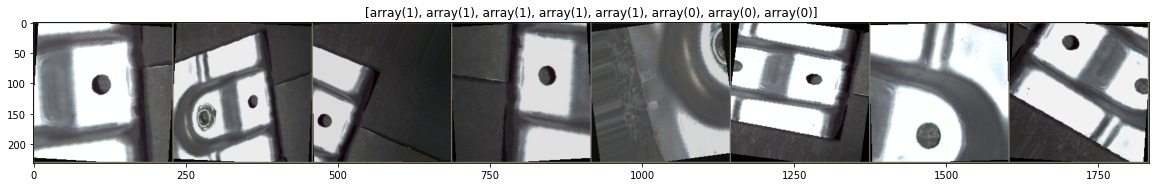

In [ ]:
#Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
#class_names = chosen_datasets['train'].classes
#Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'defected', 1:'normal'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

In [ ]:
#Load pretrained model
resnet152 = models.resnet152(pretrained=True)

#Freeze model parameters
for param in resnet152.parameters():
    param.requires_grad = False

fc_inputs = resnet152.fc.in_features
 
resnet152.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

resnet152 = resnet152.to(device)

from torchsummary import summary
print(summary(resnet152, (3, 227, 227)))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256

In [ ]:

#Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [ ]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'defected', 1:'normal'}

Train

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        #Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            #Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                #Time to carry out the forward training poss
                #We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                #We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            #Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

Visualize

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#Train and Predict

Epoch 0/5
----------
Iterating through data...


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7678 Acc: 0.5353
Iterating through data...
val Loss: 0.6626 Acc: 0.4812

Epoch 1/5
----------
Iterating through data...
train Loss: 0.6258 Acc: 0.6776
Iterating through data...
val Loss: 0.5482 Acc: 0.9710

Epoch 2/5
----------
Iterating through data...
train Loss: 0.5739 Acc: 0.7744
Iterating through data...
val Loss: 0.5326 Acc: 0.9507

Epoch 3/5
----------
Iterating through data...
train Loss: 0.5602 Acc: 0.7814
Iterating through data...
val Loss: 0.5163 Acc: 0.9594

Epoch 4/5
----------
Iterating through data...
train Loss: 0.5504 Acc: 0.8032
Iterating through data...
val Loss: 0.4942 Acc: 0.9884

Epoch 5/5
----------
Iterating through data...
train Loss: 0.5496 Acc: 0.7705
Iterating through data...
val Loss: 0.4893 Acc: 0.9913

Training complete in 2m 29s
Best val Acc: 0.991304


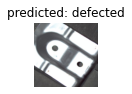

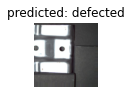

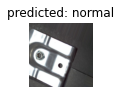

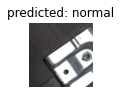

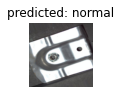

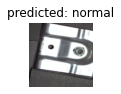

In [ ]:
base_model = train_model(resnet152, criterion, optimizer, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()